<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/Experiments/head_and_tail_tokenization_initial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Neural Network, Long Review Texts, Head and Tail Token Selection**

This experiement was one of the initial ones that the group came up with. It utilized a larger neural network than the ones that came after. Furthermore, the head and tail of the reivew texts were used for tokenization. This was done to see if the testing results would improve for more information please see the report paper included in the Github. 

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 58.6 MB/s 
     |████████████████████████████████| 596 kB 72.7 MB/s 
     |████████████████████████████████| 352 kB 76.3 MB/s 
     |████████████████████████████████| 99 kB 10.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 213 kB 36.6 MB/s 


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 4.2 MB/s 


In [ ]:
import os
import urllib, json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6190155169628391118
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8780320709667598394
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

As per the instructions included in the readme file, please connect to your drive with the necessary files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we load in the pre-trained BERT model.

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/small6.plk')

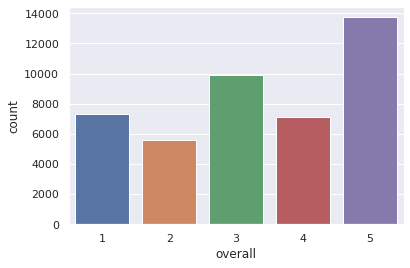

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43659 entries, 469 to 7589996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   helpful     43659 non-null  object
 1   reviewText  43659 non-null  object
 2   overall     43659 non-null  int64 
 3   summary     43659 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [ ]:
print(len(data))
len(data[data['overall'] == 5])

43659


13741

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43659 entries, 469 to 7589996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   helpful     43659 non-null  object
 1   reviewText  43659 non-null  object
 2   overall     43659 non-null  int64 
 3   summary     43659 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


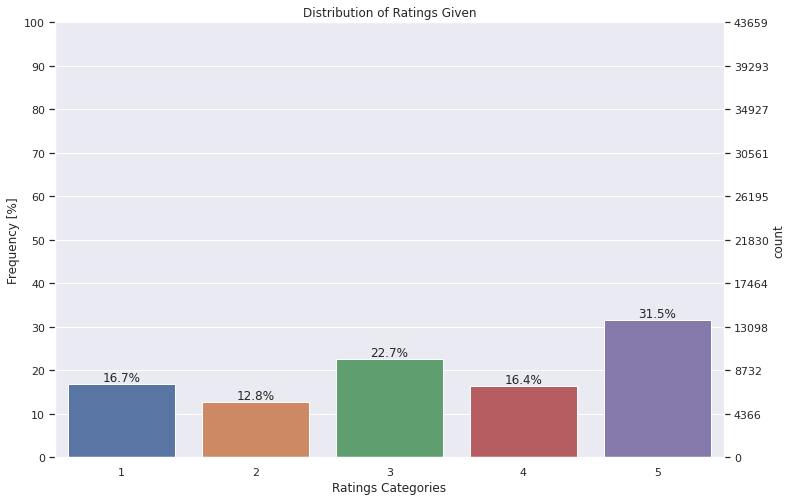

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="overall", data=data, order=[1,2,3,4,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(data)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

Below we want to make a subset of the data by taking instances of data that is in proportion to the original dataset.

In [ ]:
#20000  
# getting the 1's 
np.random.seed(10)
get_n = 3340
index_to_get = data[data.overall == 1].index
get_indices = np.random.choice(index_to_get, get_n, replace=False)
data_a = data.loc[get_indices]

# getting the 2's
np.random.seed(10)
get_n = 2560
index_to_get = data[data.overall == 2].index
get_indices = np.random.choice(index_to_get, get_n, replace=False)
data_b = data.loc[get_indices]

# getting the 3's
np.random.seed(10)
get_n = 4540
index_to_get = data[data.overall == 3].index
get_indices = np.random.choice(index_to_get, get_n, replace=False)
data_c = data.loc[get_indices]

# getting the 4's 
np.random.seed(10)
get_n = 3280
index_to_get = data[data.overall == 4].index
get_indices = np.random.choice(index_to_get, get_n, replace=False)
data_d = data.loc[get_indices]

# getting the 5's
np.random.seed(10)
get_n = 6300
index_to_get = data[data.overall == 5].index
get_indices = np.random.choice(index_to_get, get_n, replace=False)
data_e = data.loc[get_indices]




In [ ]:
data_2 = pd.concat([data_a, data_b, data_c, data_d, data_e])

data_2

,helpful,reviewText,overall,summary
5760219,"[0, 0]",I HAVE DONE EVERTHING TO MAKE THE CONTROL WOR...,1,IT DONST WORK
189037,"[0, 2]",I had to return this item because it did not w...,1,NO GOOD!
2313929,"[2, 7]",This seriously stinks! I used to buy these but...,1,Super bummed about the price.
2831281,"[8, 13]",I cannot believe Epic shovelled this game onto...,1,Pure Consolitus
5863483,"[1, 1]",I bought this for my Samsung S3.It work fine u...,1,It alread doesn't work.
...,...,...,...,...
3475489,"[0, 0]",You is fun because I get to personalize my pou...,5,Personalization
495741,"[1, 3]","Having received this via the vine program, it ...",5,Nice quality product for the price
6659639,"[0, 0]",Predatory Ethics By AthanasiosThe book opens o...,5,Predatory Ethics
1367230,"[24, 27]","This beautiful, romantic,finger-killer, arm-br...",5,Not arguably..... simply the greatest


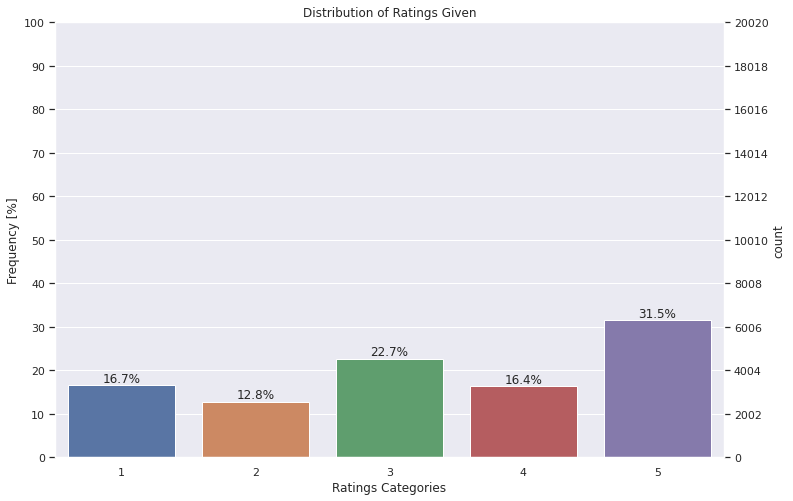

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="overall", data=data_2, order=[1,2,3,4,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(data_2)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20020 entries, 5760219 to 428902
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   helpful     20020 non-null  object
 1   reviewText  20020 non-null  object
 2   overall     20020 non-null  int64 
 3   summary     20020 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


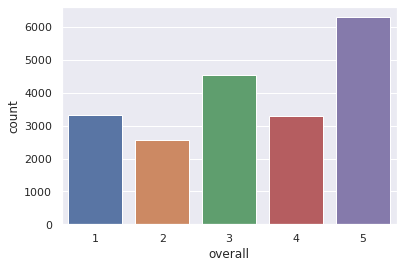

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=data_2)

In [ ]:
data_2 = data_2.sample(frac=1)
data_2

,helpful,reviewText,overall,summary
5702187,"[0, 0]",Pros: great price in category; light; no white...,3,cost-efficient speakers with drawbacks
119202,"[1, 1]",I bought this for making squash ribbons from z...,1,"Few ribbons, lots of mush!"
2593627,"[0, 0]",This is a really fun game. I had the original...,5,Great Game for Any Princess
2147151,"[0, 0]",I wanted some grounding (Earthing) shoes but w...,4,Don't put on the soles if you're using with gr...
1139210,"[3, 3]",John Coltrane demonstrates another side of his...,5,A different side of Coltrane
...,...,...,...,...
5016890,"[1, 2]","This is an OK mid-quality filter. However, it...",2,Marginal Quality
278928,"[0, 0]",Lasted 2 years of little use and died with ERR...,2,Dead with ERR. after 2 years.
2655051,"[6, 7]",I own (and am reviewing) several Nerf Super So...,3,"Cool idea, but inferior to the cheaper Scatter..."
5198500,"[2, 2]","They are inexpensive enough. However, use car...",3,KOSS Headset Cushions


In [ ]:
import sklearn

x = data_2.reviewText.values
y = data_2.overall.values


def data_split(examples, labels, train_frac = 0.8, random_state=None):


    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = sklearn.model_selection.train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = sklearn.model_selection.train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

x_train, x_val, x_test,  y_train, y_val, y_test = data_split(x,y,0.8,32)

In [ ]:
print(x_train.shape)

(16016,)


2057
5070


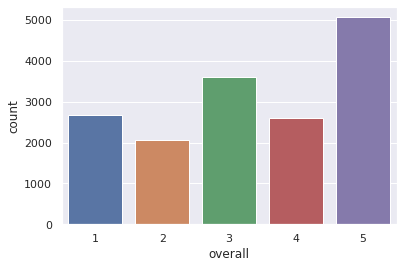

In [ ]:
print(len(y_train[y_train == 2]))
print(len(y_train[y_train==5]))
dist_y = pd.DataFrame(y_train, columns=["overall"])
sns.set_theme()
ax = sns.countplot(x="overall", data=dist_y)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)
dummy_y_train = to_categorical(encoded_Y_train)

Below, the head+tail token selection is done.

In [ ]:

def encode_names(n):

   tokens = list(tokenizer.tokenize(n)[:127]+tokenizer.tokenize(n)[-381:])
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized reviews shape', reviews.shape.as_list())

Tokenized reviews shape [16016, None]


In [ ]:
x_train[0]

"The quality and the design of Ergobaby products are always excellent.  After using this a few times I have found that this swaddler definitely has some advantages over swaddle blankets or swaddlers from makers like Halo or Summer Infant.While I like some of the features that the Babyergo has, like the arm pockets and the changing leg pocket, with my kids it seems like they like to be tightly swaddled all over and the leg pocket doesn't support their legs enough.  The materials used feel very high quality andWe have tried many of these swaddlers because I thought there would be something better and faster than the basic swaddle blankets that we first stared with.  As I have become more proficient in swaddling the infants, I find that I still choose to use theAden By aden + anais Muslin Swaddle Blanket 4 Pack, Safari Friends.  These swaddle blankets are very versatile.  We carried them with us with our first child up until he was about 2.  They are light and thin so as a swaddler they k

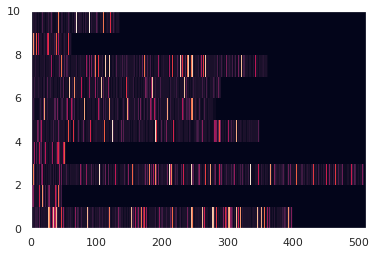

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

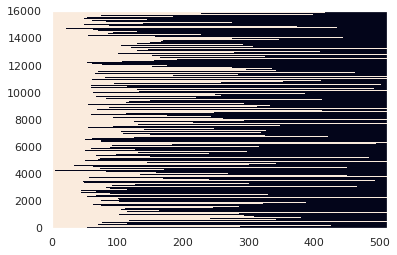

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

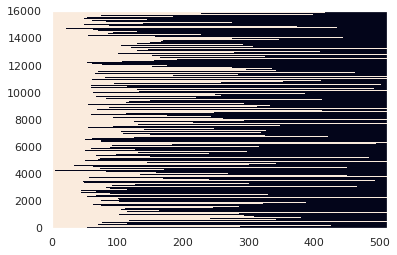

In [ ]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
lens = [len(i) for i in input_word_ids]

#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [ ]:
#max_seq_length = int(1.5*max_seq_length)
#print('Max length is:', max_seq_length)

In [ ]:

#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [ ]:

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
max_seq_length = 512


The BERT encoding is done below.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)  
X_test = bert_encode(x_test, tokenizer, max_seq_length)


In [ ]:
epochs = 4
batch_size = 8
eval_batch_size = batch_size
LR = 2e-5

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])


output = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L2(0.01), activity_regularizer= tf.keras.regularizers.L1(0.01), activation='relu')(pooled_output)
output = tf.keras.layers.Dropout(rate=0.1)(output) 
output = tf.keras.layers.Dense(256)(output)
output = tf.keras.layers.Dense(128)(output)
output = tf.keras.layers.Dense(64, activation='relu')(output)
output = tf.keras.layers.Dropout(rate=0.1)(output)
output = tf.keras.layers.Dense(5, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)


In [ ]:
pooled_output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model.compile(tfa.optimizers.RectifiedAdam(learning_rate=LR), # try sgd  
              loss='categorical_crossentropy',
              metrics=['accuracy'],
  
              )

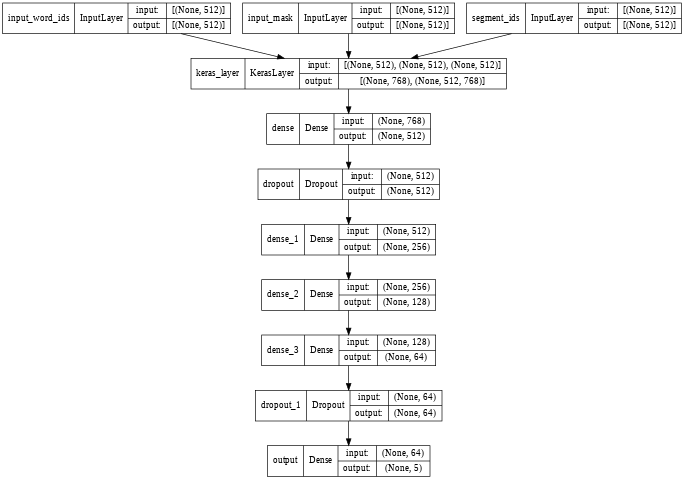

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/4
2002/2002 [==============================] - 1263s 620ms/step - loss: 6.6943 - accuracy: 0.4735 - val_loss: 5.0482 - val_accuracy: 0.5859
Epoch 2/4
2002/2002 [==============================] - 1240s 620ms/step - loss: 3.6614 - accuracy: 0.6098 - val_loss: 2.5868 - val_accuracy: 0.5929
Epoch 3/4
2002/2002 [==============================] - 1240s 619ms/step - loss: 1.7649 - accuracy: 0.6836 - val_loss: 1.6186 - val_accuracy: 0.5924
Epoch 4/4
2002/2002 [==============================] - 1240s 619ms/step - loss: 1.0199 - accuracy: 0.7647 - val_loss: 1.4407 - val_accuracy: 0.5964


In [ ]:
X_val = bert_encode(x_val, tokenizer, max_seq_length)
encoded_Y_val = encoder.transform(y_val)
dummy_y_val = to_categorical(encoded_Y_val)

In [ ]:
loss, accuracy = model.evaluate(X_val, dummy_y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5944


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y_val, y_pred_bool, labels=[1,2,3,4,5], digits=4))

251/251 [==============================] - 48s 188ms/step
              precision    recall  f1-score   support

           1     0.7184    0.6796    0.6985       334
           2     0.4354    0.3597    0.3939       253
           3     0.5616    0.5915    0.5762       470
           4     0.3754    0.3469    0.3606       343
           5     0.7143    0.7890    0.7498       602

    accuracy                         0.5944      2002
   macro avg     0.5610    0.5534    0.5558      2002
weighted avg     0.5858    0.5944    0.5888      2002



In [ ]:
# Get Accuracy By Category
def get_accuracy_category(y_pred_bool, y_true):
  y_true_cat1 = y_true[y_true == 1]
  y_pred_true_cat1 = y_pred_bool[y_true == 1]
  num_correct_cat1 = len(y_pred_true_cat1[y_pred_true_cat1 == 1])

  y_true_cat2 = y_true[y_true == 2]
  y_pred_true_cat2 = y_pred_bool[y_true == 2]
  num_correct_cat2 = len(y_pred_true_cat2[y_pred_true_cat2 == 2])

  y_true_cat3 = y_true[y_true == 3]
  y_pred_true_cat3 = y_pred_bool[y_true == 3]
  num_correct_cat3 = len(y_pred_true_cat3[y_pred_true_cat3 == 3])

  y_true_cat4 = y_true[y_true == 4]
  y_pred_true_cat4 = y_pred_bool[y_true == 4]
  num_correct_cat4 = len(y_pred_true_cat4[y_pred_true_cat4 == 4])

  y_true_cat5 = y_true[y_true == 5]
  y_pred_true_cat5 = y_pred_bool[y_true == 5]
  num_correct_cat5 = len(y_pred_true_cat5[y_pred_true_cat5 == 5])

  return (num_correct_cat1/len(y_true_cat1), num_correct_cat2/len(y_true_cat2), num_correct_cat3/len(y_true_cat3), num_correct_cat4/len(y_true_cat4), num_correct_cat5/len(y_true_cat5))



In [ ]:
category_accuracy = get_accuracy_category(y_pred_bool, y_val)
category_accuracy

(0.6796407185628742,
 0.35968379446640314,
 0.5914893617021276,
 0.3469387755102041,
 0.7890365448504983)

In [ ]:
y_pred_bool[y_pred_bool != 5]

array([4, 2, 4, ..., 1, 2, 3])

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

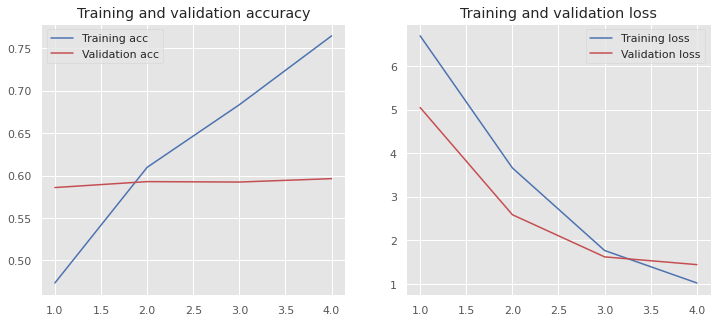

In [ ]:
plot_history(history)

In [ ]:
model_fname = 'Bert_5_category_head_and_tail_tokenization'
my_wd = '/content/drive/My Drive'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/drive/My Drive/Ratings_BERT_12/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Ratings_BERT_12/assets


In [ ]:
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_val, dummy_y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5739


In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

[UNK] [100]
' [1005]
t [1056]
get [2131]
me [2033]
wrong [3308]
, [1010]
it [2009]
does [2515]
take [2202]
the [1996]
makeup [5789]
right [2157]
off [2125]
your [2115]
face [2227]
. [1012]
[UNK] [100]
as [2004]
others [2500]
mentioned [3855]
, [1010]
it [2009]
does [2515]
leave [2681]
a [1037]
thick [4317]
##ish [4509]
film [2143]
on [2006]
your [2115]
face [2227]
. [1012]
[UNK] [100]
' [1005]
ve [2310]
been [2042]
using [2478]
the [1996]
product [4031]
for [2005]
only [2069]
a [1037]
few [2261]
days [2420]
and [1998]
have [2031]
noticed [4384]
tiny [4714]
pi [14255]
##mple [23344]
##s [2015]
that [2008]
[UNK] [100]
have [2031]
in [1999]
regions [4655]
where [2073]
[UNK] [100]
[UNK] [100]
break [3338]
out [2041]
usually [2788]
. [1012]
[UNK] [100]
' [1005]
m [1049]
unsure [12422]
if [2065]
it [2009]
' [1005]
s [1055]
just [2074]
a [1037]
common [2691]
breakout [25129]
or [2030]
if [2065]
these [2122]
wipe [13387]
##s [2015]
caused [3303]
it [2009]
. [1012]
